# Project 2: In-Depth Exploratory Data Analysis (EDA)
## Netflix Content Analysis 🎬

**Project Objective:** To perform an in-depth exploratory data analysis of the Netflix dataset. We will explore trends in content production, identify popular genres, analyze content ratings, and understand the distribution of movies and TV shows on the platform. This project builds on foundational EDA by introducing time-series analysis and more complex data cleaning and transformation techniques.

**Class Duration:** 2.5 hours

### Core Concepts We'll Cover:
1.  **Data Cleaning & Transformation:** Handling missing values and converting data types (especially dates).
2.  **Time-Series Analysis:** Analyzing how content has been added to Netflix over the years.
3.  **Text Data Manipulation:** Parsing and analyzing columns with multiple values, like `listed_in` (genres) and `cast`.
4.  **Geographical & Rating Analysis:** Understanding where content comes from and its maturity level.
5.  **Feature Engineering:** Creating new, insightful features like 'content age'.
6.  **Advanced Visualization:** Creating insightful plots to understand distributions and relationships in the data.

### Step 1: Setup - Importing Libraries

As always, we begin by importing our essential data science toolset, including a new library for word clouds.

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

### Step 2: Data Loading and Initial Inspection

We'll load the `netflix_titles.csv` dataset and perform a high-level overview.

In [308]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [309]:
netflix_df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [310]:
# Get a concise summary of the dataframe
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


**Interpretation of `.info()`:**
- We have 7787 entries (titles).
- **Key Problem:** The `date_added` column is of type `object` (a string), not a `datetime` object. We cannot perform time-based analysis until this is corrected.
- **Missing Values:** `director`, `cast`, `country`, `date_added`, and `rating` all have missing values. `director` has the most significant number of nulls.

### Step 3: Data Cleaning and Transformation

This step is critical for ensuring our analysis is accurate. We will handle missing values and correct data types.

#### **Theoretical Concept: Data Type Conversion & Handling Nulls**
Data often comes in non-ideal formats. Storing dates as strings, for example, prevents us from extracting components like the year or month, or from plotting data over time. Converting columns to their proper data types (`pd.to_datetime`, `.astype()`) is a fundamental preprocessing step.

For null values, we have several strategies:
1.  **Drop:** If only a very small percentage of rows have missing data, dropping them might be acceptable (`.dropna()`).
2.  **Fill/Impute:** Replace missing values with a placeholder (like "Unknown") or a statistical measure (like the mode for categorical data). This is useful when you don't want to lose the other information in those rows.

In [311]:
# 1. Handle missing values in 'director' and 'cast'
# Since these are text fields and many are missing, we'll fill them with 'Unknown'.
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

In [312]:
# 2. Handle missing 'country'
# We'll fill with the mode, which is the most common country.
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

In [313]:
# 3. Drop the few rows with missing 'date_added' and 'rating'
# Since the number is small (less than 0.2% of data), dropping them is a safe option.
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [314]:
# 4. Convert 'date_added' to datetime objects
# Use format='mixed' to handle potential variations in date formats
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)

* **format='mixed':** This argument tells pandas to infer the date format automatically. This is helpful when the date strings in the column have different formats.

* **dayfirst=False:** This argument specifies that when the date format is ambiguous (e.g., 01/02/2023), it should be interpreted as month first (January 2nd) rather than day first (February 1st).

In [315]:
# 5. Create new features for year and month added
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [316]:
# Verify our cleaning and transformation
print("Missing values after cleaning:")
print(netflix_df.isnull().sum())
print("\nData types after transformation:")
print(netflix_df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after transformation:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


### Step 4: Exploratory Data Analysis & Visualization

# Submission Q's

* How has the distribution of content ratings changed over time?
* Is there a relationship between content age and its type (Movie vs. TV Show)?
* Can we identify any trends in content production based on the release year vs. the year added to Netflix?
* What are the most common word pairs or phrases in content descriptions?
* Who are the top directors on Netflix?

**Q1)How has the distribution of content ratings changed over time?**

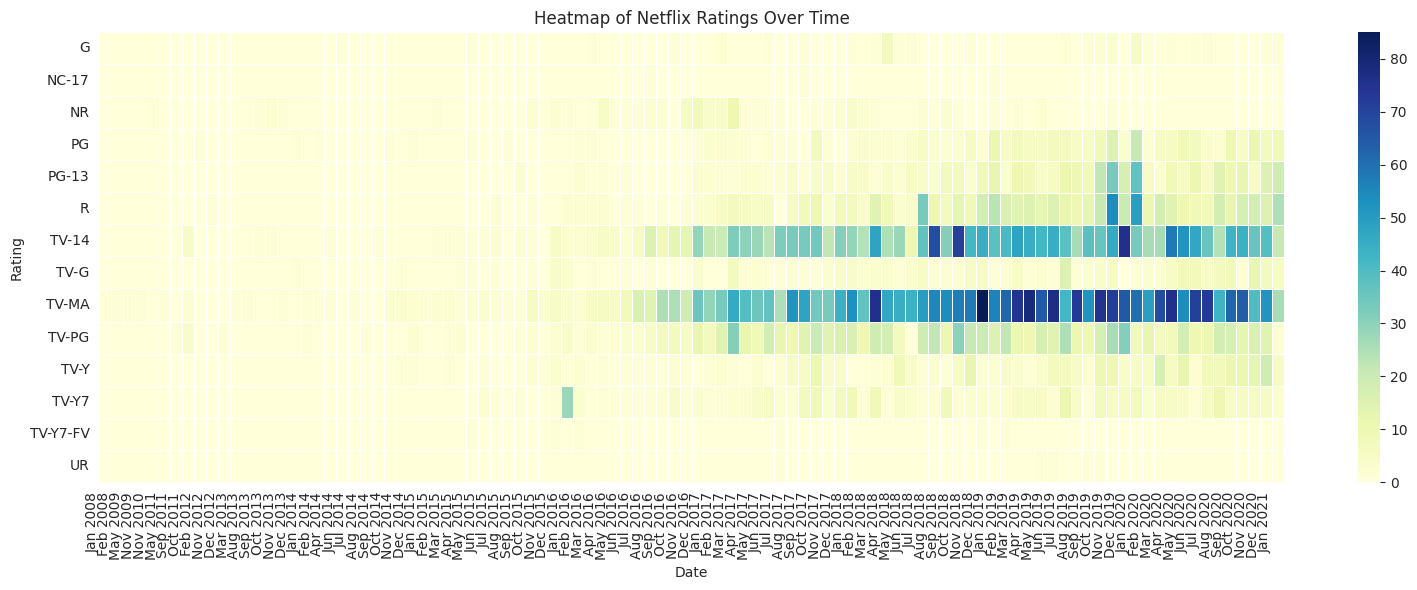

In [317]:
rating_distribution['date'] = pd.to_datetime(rating_distribution['year_added'].astype(str) + '-' +rating_distribution['month_added'].astype(str))

heatmap_data = rating_distribution.pivot_table(index='rating',columns='date',values='count',fill_value=0)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)


plt.xticks(ticks=range(len(heatmap_data.columns)),labels=heatmap_data.columns.strftime('%b %Y'),rotation=90,ha='right')

plt.title('Heatmap of Netflix Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()


**Q2)Is there a relationship between content age and its type (Movie vs. TV Show)?**

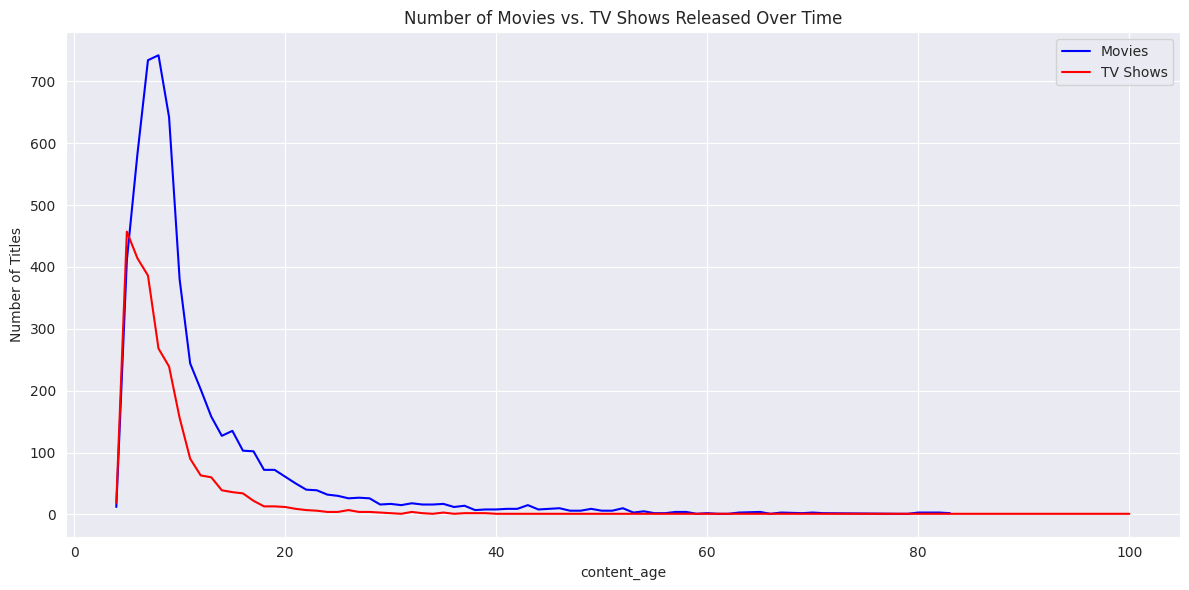

In [318]:
yearly_counts = (netflix_df.assign(content_age=datetime.now().year - netflix_df['release_year']).groupby(['content_age', 'type']).size().reset_index(name='count').sort_values(by='content_age'))


plt.figure(figsize=(12, 6))
plt.plot(yearly_counts[yearly_counts['type'] == 'Movie']['content_age'], yearly_counts[yearly_counts['type'] == 'Movie']['count'], label='Movies', color='blue')
plt.plot(yearly_counts[yearly_counts['type'] == 'TV Show']['content_age'],yearly_counts[yearly_counts['type'] == 'TV Show']['count'], label='TV Shows', color='red')

plt.title('Number of Movies vs. TV Shows Released Over Time')
plt.xlabel('content_age')
plt.ylabel('Number of Titles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Q3)Can we identify any trends in content production based on the release year vs. the year added to Netflix?**

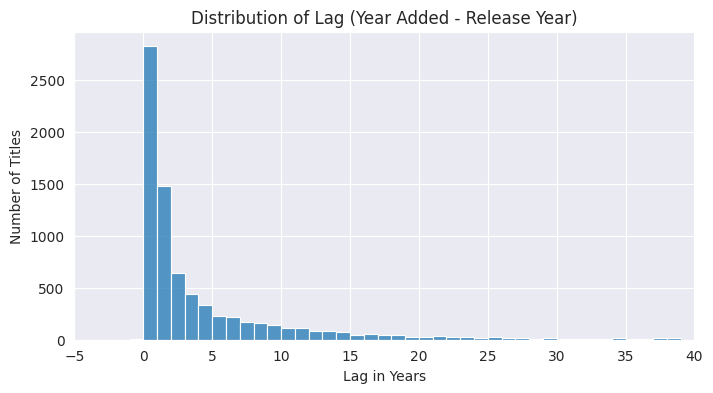

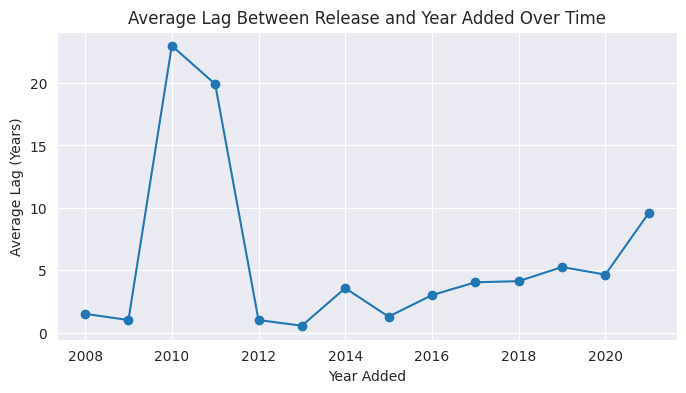

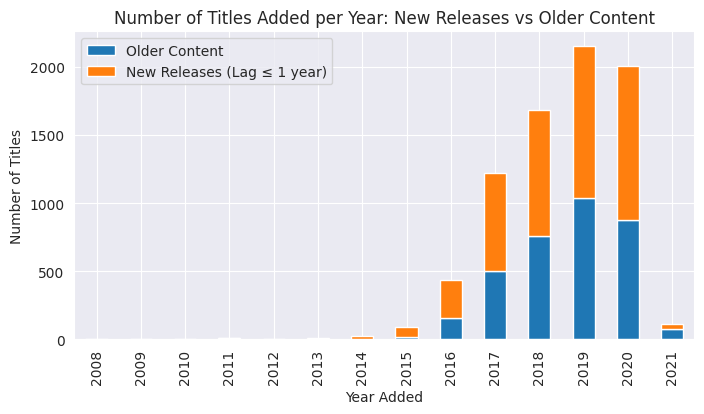

In [325]:
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], errors='coerce')
netflix_df['year_added'] = netflix_df['date_added'].dt.year
df_clean = netflix_df.dropna(subset=['year_added', 'release_year'])


df_clean['lag'] = df_clean['year_added'] - df_clean['release_year']


plt.figure(figsize=(8,4))
sns.histplot(df_clean['lag'], bins=range(-10, 40), kde=False)
plt.title('Distribution of Lag (Year Added - Release Year)')
plt.xlabel('Lag in Years')
plt.ylabel('Number of Titles')
plt.xlim(-5, 40)
plt.show()


avg_lag_per_year = df_clean.groupby('year_added')['lag'].mean()

plt.figure(figsize=(8,4))
avg_lag_per_year.plot(marker='o')
plt.title('Average Lag Between Release and Year Added Over Time')
plt.xlabel('Year Added')
plt.ylabel('Average Lag (Years)')
plt.grid(True)
plt.show()


df_clean['is_new_release'] = df_clean['lag'] <= 1
counts = df_clean.groupby(['year_added', 'is_new_release']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title('Number of Titles Added per Year: New Releases vs Older Content')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(['Older Content', 'New Releases (Lag ≤ 1 year)'])
plt.show()


**Q4)What are the most common word pairs or phrases in content descriptions?**

In [319]:
import re
from collections import Counter

text = ' '.join(netflix_df['description'].dropna()).lower()

text = re.sub(r'[^\w\s a]', '', text)

word_freq = Counter(text.split())

df = pd.DataFrame(word_freq.items(), columns=['word', 'count'])

# as all df['count'] less tha 742 were very common words
df[df['count'] < 742].sort_values(by='count', ascending=False).head().reset_index(drop=True).head()




,word,count
0,life,694
1,but,681
2,at,662
3,young,655
4,into,614


Q5)Who are the top directors on Netflix?

In [320]:
netflix_df['director'] = netflix_df['director'].dropna()


directors_expanded = netflix_df['director'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
directors_expanded.name = 'director'

top_directors = directors_expanded.value_counts().head(10)

print("Top 10 directors on Netflix:")
print(top_directors)


Top 10 directors on Netflix:
director
Unknown                2376
Jan Suter                21
Raúl Campos              19
Marcus Raboy             16
Jay Karas                15
Cathy Garcia-Molina      13
Youssef Chahine          12
Martin Scorsese          12
Jay Chapman              12
Steven Spielberg         10
Name: count, dtype: int64
